# <center> Predicting Critical Violations of Health Code: Dining in Las Vegas   

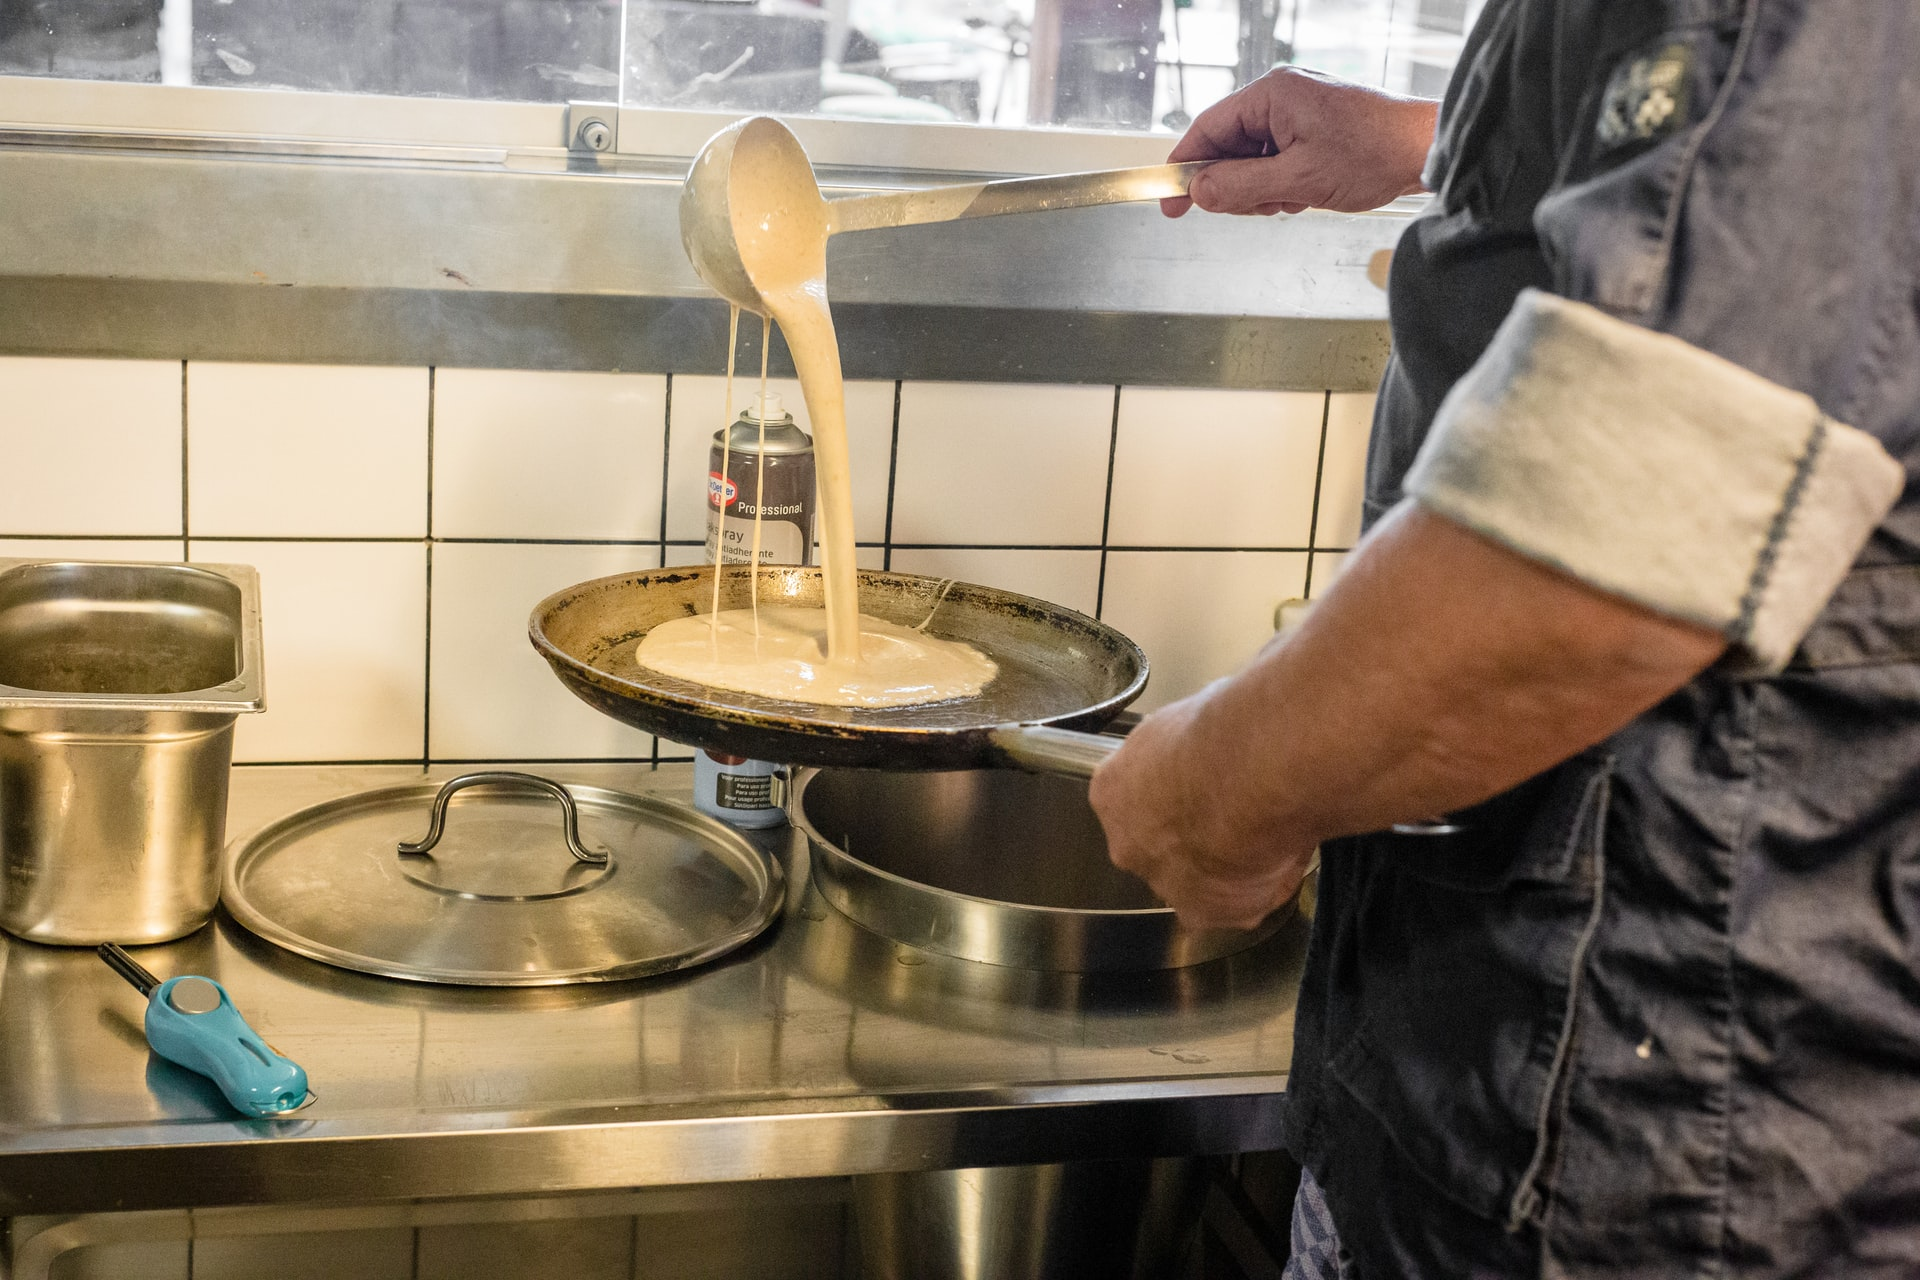
Photo by Louis Hansel on [unsplash.com](https://unsplash.com/photos/AI884OpAgnQ)

Restaurants are frequent settings for foodborne illness outbreaks. Periodic inspection of restaurants is crucial to ensure commercial food establishments carry out safe food handling procedures. Predictive analytics can help identify problematic restaurants and maximize the utility of limited enforcement resources. 

This notebook describes a prototype of a major insurance firm's MVP machine learning model. The model predicts restaurants and other dining venues likely to face critical health code challenges in Las Vegas during the next inspection period.

The final model uses five numeric features to predict if a restaurant receives a C grade or below during the inspection (i.e., critical violation of sanitary practices). Three predictors refer to employee characteristics; the remaining two features describe the degree of violations. The model is a good tool if the purpose is to identify as many problematic restaurants as possible. The model could correctly identify 80% of problematic restaurants in a holdout test data set. At the same time, the model misclassified many compliant restaurants as non-compliant ones.

# Initial Data Exploration and Observations
I converted all uppercase characters in column names into lowercase characters to facilitate data manipulation. I also renamed the target variable to 'target.'

The concise summary of the dataframe indicates that many rows have some missing values. The heat map shows that missing values do not seem to occur because of a systematic reason. As such, the missing values can be imputed without introducing a significant bias to the data.

While the dataframe contains many features, my unreported exploratory analyses indicate that most of these features are neither predictive of the target nor necessary. For instance, the information contained in 'current_grade' is already reflected in 'current_demerits.' As such, I focus my analyses on numeric features that tend to contain richer information compared to categorical data. I focus on the following five numeric features: 
- current_demerits
- employee_count
- inspection_demerits
- median_employee_age
- median_employee_tenure

In [1]:
#import Python libraries
import pandas as pd
pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.width', None)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(17, 4)})
import warnings
warnings.filterwarnings('ignore')

In [2]:
#read in the dataset into dataframe and display three randomly selected rows
df = pd.read_csv('TRAIN_SET_2021.csv')
df.columns = df.columns.str.lower()
df.rename(columns = {'next_inspection_grade_c_or_below':'target'}, inplace = True) 
df.sample(3)

,restaurant_serial_number,restaurant_permit_number,restaurant_name,restaurant_location,restaurant_category,address,city,state,zip,current_demerits,current_grade,employee_count,median_employee_age,median_employee_tenure,inspection_time,inspection_type,inspection_demerits,violations_raw,record_updated,lat_long_raw,first_violation,second_violation,third_violation,first_violation_type,second_violation_type,third_violation_type,number_of_violations,target
15041,DA0635676,PR0024565,I Love Yogurt - DELETED 7/21/15 MS,I LOVE YOGURT,Restaurant,11700 W Charleston Blvd,Las Vegas,Nevada,89135-1573,6.0,A,20.0,22.921223,5.466602,7/17/2010 14:00,Routine Inspection,10,"4,24,37,114",2/21/2013 22:26,"(36.1600724, 115.350056)",4.0,24.0,37.0,Major,Non-Major,Non-Major,4,0
14184,DA0954112,PR0022133,Aces and Ales Restaurant,Aces and Ales,Restaurant,3740 S Nellis Blvd,Las Vegas,Nevada,89121-3112,0.0,A,14.0,30.288332,2.020868,2/22/2012 14:20,Routine Inspection,10,"211,214,221,229",2/21/2013 22:26,"(36.121679, 115.064799)",211.0,214.0,221.0,Major,Major,Major,4,0
87,DA0313521,PR0007357,Boulder Station Buffet Dishroom,Boulder Station Hotel & Casino,Special Kitchen,4111 Boulder Hwy,Las Vegas,Nevada,89121-2510,3.0,A,23.0,18.000000,3.166994,7/1/2010 9:00,Routine Inspection,6,"14,36,37",2/21/2013 22:26,"(36.1337103, 115.0850568)",14.0,36.0,37.0,Major,Non-Major,Non-Major,3,0


In [3]:
#display number of missing variables per column
df.isnull().sum()

restaurant_serial_number      0
restaurant_permit_number      0
restaurant_name              65
restaurant_location         200
restaurant_category         130
address                      70
city                        236
state                       209
zip                          59
current_demerits            216
current_grade               308
employee_count               93
median_employee_age          34
median_employee_tenure      297
inspection_time             183
inspection_type             221
inspection_demerits         254
violations_raw              165
record_updated              119
lat_long_raw                 15
first_violation             212
second_violation             85
third_violation              61
first_violation_type        146
second_violation_type       267
third_violation_type        173
number_of_violations        169
target                       40
dtype: int64

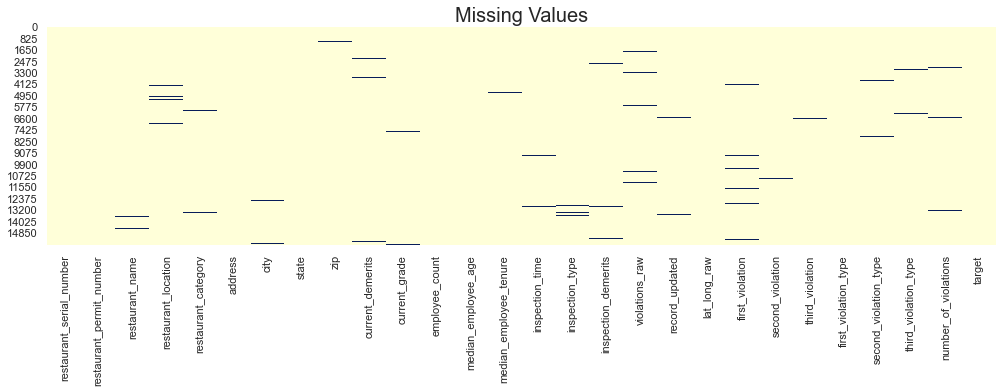

In [4]:
# create heatmap for missing values
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
plt.title('Missing Values', fontsize=20)
plt.show()

# Cleaning Target Variable
To explore the target column, I created a frequency distribution table. The table reveals that the most common values are coded 0 and 1. Additionally, the column contains 40 missings values and some erroneous entries. I slice the dataframe that contains only 0 and 1 values and convert the column to the integer type to address these issues. The resulting dataframe contains 84% of values coded 1, while the remaining 16% were coded 0.

In [5]:
# create frequency distribution table for the target column
df.target.value_counts(dropna=False)

0       13143
1        2484
NaN        40
-3          1
Goat        1
7           1
9           1
4           1
3           1
Name: target, dtype: int64

In [6]:
#slice the df
df = df[(df.target == '1') | (df.target == '0')]
df.target = df.target.astype('int')

In [7]:
# create frequency distribution table for target column after slicing df
round(df.target.value_counts(normalize=True, dropna=False)*100,0)

0    84.0
1    16.0
Name: target, dtype: float64

# Cleaning Features
The frequency distribution table for the current_demerits columns indicates that the columns contain missing, unusually high, float, and negative values. The column should contain only natural numbers not exceeding 87. To address this issue, I replace values outside this criterion as missing, fill missing values with a mean value, and convert the column to the integer type. I follow a similar procedure to clean the remaining five features.

In [8]:
# create frequency distribution table for current_demerits column
df.current_demerits.value_counts(dropna=False)

 0.00       3920
 3.00       3115
 8.00       2437
 6.00       2198
 9.00       1868
 5.00        763
 10.00       449
 NaN         216
 7.00        111
 19.00        73
 4.00         60
 20.00        50
 1.00         48
 2.00         35
 14.00        34
 17.00        23
 27.00        16
 11.00        16
 12.00        15
 25.00        13
 22.00        13
 32.00        13
 16.00        11
 18.00        11
 31.00        10
 30.00         9
 46.00         9
 100.00        8
 51.00         7
 13.00         7
 23.00         7
 42.00         7
 24.00         6
 35.00         6
 26.00         6
 39.00         6
 28.00         5
 15.00         5
 38.00         5
 43.00         3
 21.00         2
 37.00         1
 33.00         1
 87.00         1
 88.00         1
 98.00         1
 363.00        1
 89.00         1
 1214.00       1
-8.00          1
 48.00         1
 3.14          1
Name: current_demerits, dtype: int64

In [9]:
#cleaing current_demerits
df.current_demerits.replace([1214, 89, 88, 363, 100, 98, -8.00, 3.14] , np.nan, inplace=True )
df.current_demerits.fillna(round(df.current_demerits.mean(), 0), inplace=True)
df.current_demerits = df.current_demerits.astype('int')

#cleaning employee_count
df.employee_count.replace([687, 111447, -7, 902] , np.nan, inplace=True )
df.employee_count = df.employee_count.astype('float')
df.employee_count.fillna(round(df.employee_count.mean(), 0), inplace=True)
df.employee_count = df.employee_count.astype('int')

#cleaning inspection_demerits
df.inspection_demerits.replace('Routine Inspection', np.nan, inplace=True )
df.inspection_demerits = df.inspection_demerits.astype('float')
df.inspection_demerits.fillna(round(df.inspection_demerits.mean(), 0), inplace=True)
df.inspection_demerits = df.inspection_demerits.astype('int')

#cleaning number_of_violations
df.number_of_violations.replace('Nevada', np.nan, inplace=True )
df.number_of_violations = df.number_of_violations.astype('float')
df.number_of_violations.fillna(round(df.number_of_violations.mean(), 0), inplace=True)
df.number_of_violations = df.number_of_violations.astype('int')

#cleaning median_employee_age
df.median_employee_age.fillna(round(df.median_employee_age.mean(), 0), inplace=True)

#cleaning median_employee_tenure
df.median_employee_tenure.fillna(round(df.median_employee_tenure.mean(), 0), inplace=True)

# Feature Selection
The next thing to look for is potential collinearity between some of these feature columns. Collinearity is when two feature columns are highly correlated and risk duplicating information. If two features convey the same information using two different measures or metrics, there is no need to keep both.

I generate a correlation matrix heatmap using Seaborn to visually compare the correlations and look for problematic pairwise feature correlations. Based on the correlation matrix heatmap, the following pairs of columns are strongly correlated: 'inspection_demerits' and 'number_of_violations.' These two features reflect very similar information. Given that 'inspection_demeritts' contain more nuanced information, I drop 'number_of_violations' from further analysis.

Also, I examined the possibility of removing features with low variance. When the values in a feature column have low variance, they don't meaningfully contribute to the model's predictive capability. To make apples-to-apples comparisons between columns, I rescaled all of the columns to vary between 0 and 1. This is known as min-max scaling or as rescaling. But I finally decided to keep all five features in the model. 

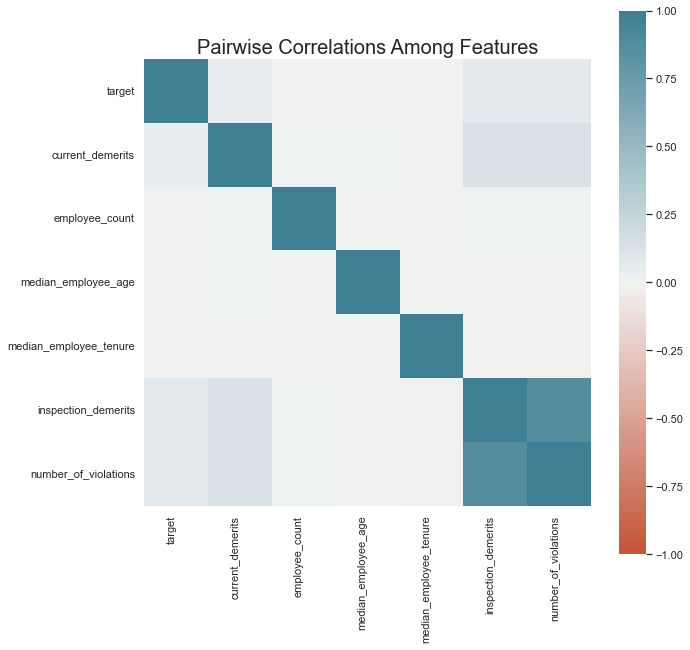

In [10]:
# Explore correlations among features
corr = df[['target', 'current_demerits', 'employee_count', 'median_employee_age', 
           'median_employee_tenure','inspection_demerits', 'number_of_violations']].corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(corr,vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
ax.set_title('Pairwise Correlations Among Features', fontsize=20)
plt.show()

# ML Modeling
To determine the predictive capacity of the ML model, I split the data into a training set and testing set. Given that the number of restaurants that receive a C grade or below for their evaluation (16%) is fewer than the remaining cases (84%), I use the ClusterCentroids method to better train the model to recognize the minority class cases. This method addresses data imbalance by undersampling the majority class by replacing a cluster of majority samples with the cluster centroid of a KMeans algorithm. 

I use the pipeline tool combined with GridSearchCV to assemble several steps that can be cross-validated while setting different parameters. The preprocessing step in the pipeline includes RobustScaler, scales features using statistics that are robust to outliers. The classifier step includes C-Support Vector Classification, Random Forrest, Logistic Regression, and Gradient Boosting classifiers.

GridSearchCV runs through all the different parameters fed into the parameter grid and produces the best combination of parameters based on a scoring metric of your choice. The recall is used as a performance metric when there is a need to identify all positive samples; that is, when it is crucial to avoid false negatives. A health code violation is a good case for this: it is vital to find all non-compliant restaurants, possibly falsely including well-maintained venues in the prediction. Thus, I use recall as an evaluation metric when ranking results.

In [11]:
#import ML libraries
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import Pipeline

In [12]:
y = df.target
X = df[['current_demerits', 'employee_count', 'median_employee_age', 'median_employee_tenure', 'inspection_demerits']] 

In [13]:
# Create the pipeline
pipe = Pipeline([('preprocessing', RobustScaler()), ('classifier', SVC())])

In [14]:
# Specify the hyperparameter space
parameters = [
{'classifier': [RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced')],
'preprocessing': [None],     
'classifier__n_estimators': [100, 200, 300],
'classifier__max_features': ['auto', 3, 4, 5],
'classifier__max_depth': [None, 2, 3, 100],    
'classifier__criterion': ['gini', 'entropy'],
'classifier__min_samples_leaf': [3, 4, 5],
'classifier__min_samples_split': [8, 10, 12]},
    
{'classifier': [SVC(random_state=0, class_weight='balanced')], 
'preprocessing': [RobustScaler(), None],
'classifier__gamma': [0.01, 0.1, 1, 10, 100],
'classifier__C': [0.01, 0.1, 1, 10, 100]},  

{'classifier': [GradientBoostingClassifier(random_state=0)], 
'preprocessing': [None],
'classifier__learning_rate': [0.01, 0.1, 1, 10],
'classifier__n_estimators': [100, 200, 300],
'classifier__max_depth': [2, 3, 5]},

{'classifier': [LogisticRegression(n_jobs=-1, max_iter=1000)], 
'preprocessing': [RobustScaler(), None], 
'classifier__C': [0.01, 0.1, 1, 10, 100]}
]

In [15]:
# Instantiate GridSearchCV object
grid = GridSearchCV(pipe, param_grid=parameters, cv=5, scoring='recall')

In [16]:
# Define resampling method
method = ClusterCentroids(random_state=0)

In [17]:
# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

In [18]:
# Fit to the training set
model = grid.fit(X_resampled, y_resampled)

# Results
The exhaustive search identified the best parameters: SVC with the regularization parameter of 0.1 and gamma parameter for non-linear hyperplanes of 0.01 in combination with RobustScaler. This model produced a recall score for problematic restaurants of 0.82. Because this test set recall score of the model is the same as the cross-validation recall score during training, the model is not likely to overfit and can be considered reliable.

Best params:
{'classifier': SVC(C=0.1, class_weight='balanced', gamma=0.01, random_state=0), 'classifier__C': 0.1, 'classifier__gamma': 0.01, 'preprocessing': RobustScaler()}

Best cross-validation score: 0.82
Test set score: 0.82
              precision    recall  f1-score   support

           0       0.83      0.17      0.28      3286
           1       0.16      0.82      0.26       621

    accuracy                           0.27      3907
   macro avg       0.49      0.49      0.27      3907
weighted avg       0.72      0.27      0.28      3907



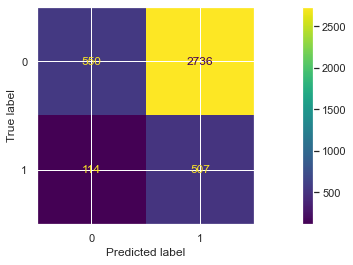

In [19]:
# Get performance metrics
predict = model.predict(X_test)

print("Best params:\n{}\n".format(model.best_params_))
print("Best cross-validation score: {:.2f}".format(model.best_score_))
print("Test set score: {:.2f}".format(model.score(X_test, y_test)))
plot_confusion_matrix(model, X_test, y_test)
print (classification_report(y_test, predict))

# Conclusion
The final model uses five numeric features to predict if a restaurant receives a C grade or below during the inspection. Three predictors refer to employee characteristics; the remaining three variables describe the degree of violations. The model is a good tool if the purpose is to identify as many problematic restaurants as possible. The model could correctly identify 82% of problematic restaurants in a holdout test data set. At the same time, the model misclassified many compliant restaurants as non-compliant ones. 

There is plenty of room to improve the model's predictive capacity by supplementing it with additional data sources. For instance, employee characteristics in the current model had decent effect sizes. Additional descriptive information about employees, such as experience and training in safe food preparation practices, may improve the model substantially. In addition to employees' ability, motivation and incentives to practice safe food handling (or cut corners to maximize lower quality output in the kitchen) are also essential components that may explain and predict (in)compliance by restaurants. Other projects were able to leverage social media in predicting outcomes of health inspections. For instance, Uppoor et al. used data from Yelp reviews ([see PDF](https://cseweb.ucsd.edu/classes/wi15/cse255-a/reports/fa15/036.pdf)). However, the authors reported that it was more challenging to predict critical violations than minor problems.